# Neural Collaborative Filtering network
We're going to take the Neural Collaborative Filtering network structure and include as many modules as possible.

Reference:  https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c 

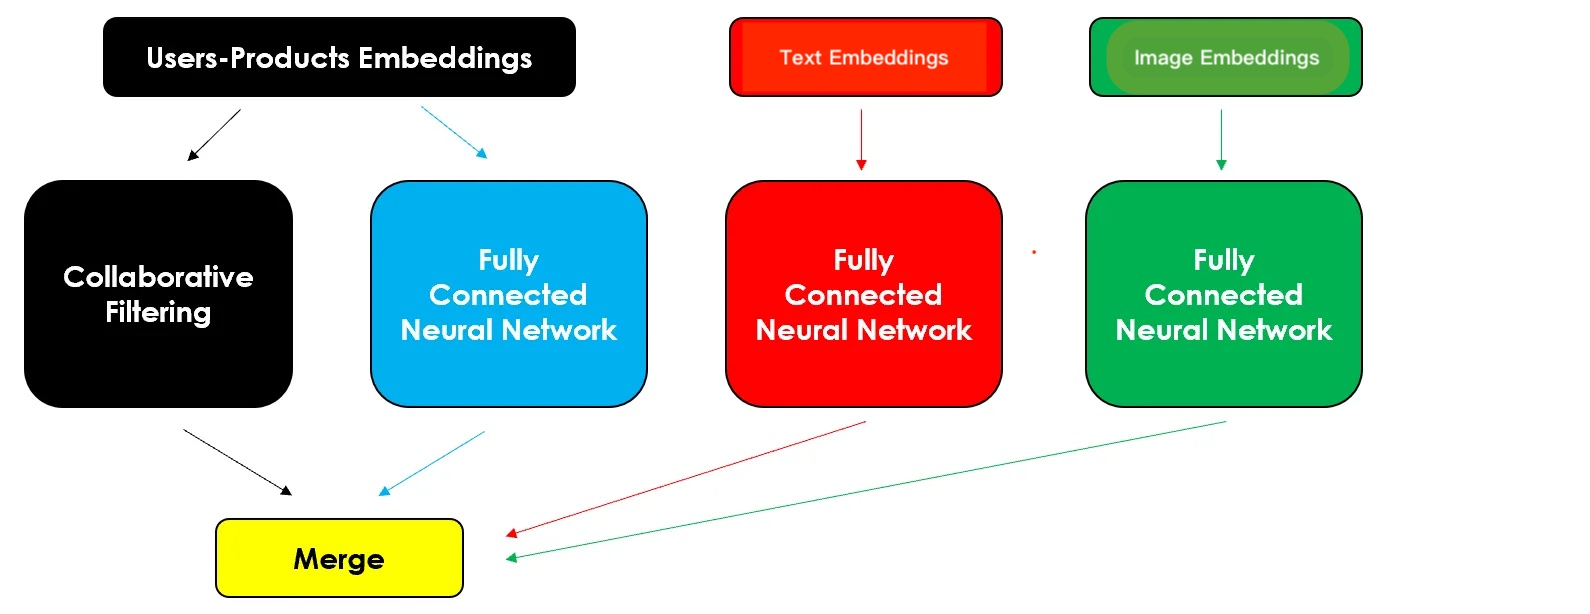

In [1]:
from IPython import display
display.Image("CDL.jpg")

In [ ]:
# Import the necessary libraries
import os
import pandas as pd
import numpy as np



product_data = pd.read_json('meta_AMAZON_FASHION.json', lines=True)
user_data= pd.read_json('AMAZON_FASHION.json', lines=True)

print('--------------------------------product_data----------------------------------------','\n')
print(product_data.info(),'\n')
print('----------------------------------user_data-----------------------------------------','\n')
print(user_data.info(),'\n')

# Image feature extraction package
def imageFeaturesProcessing(product_data,num_pic):
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    
    # Image setiing 
    img_size = (32, 32)
    img_folder_path = "./image_file/"
    
    # Pre-train CV model 
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    
    def extract_image_features(filename, model):    
        img = load_img(filename, target_size=img_size)
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = model.predict(img)
        img = img.flatten()
        return img
    
    new_product_df = pd.DataFrame(columns = {'title','asin','description','image'})
    for file in os.listdir(img_folder_path)[:num_pic]:
        asin = file.split('.')[0]
        if asin in list(product_data['asin']):
            try:
                img = extract_image_features(img_folder_path+file,vgg16_model)
                new_product_df = new_product_df.append({'asin':asin, 'title' :product_data[product_data['asin'] == asin]['title'].values[0], 'description' : product_data[product_data['asin'] == asin]['title'].values[0], 'image':img},ignore_index=True)
                #metadata.loc[metadata['asin'] == 'asin', 'imageURL'] = asin+'.jpg'
            except Exception as e:
                print(e)
    return new_product_df

product_data = imageFeaturesProcessing(product_data,1200)
print('----------------------------precrocessed_product_data-----------------------------------','\n')
print(product_data.info(),'\n')

In [ ]:
def dfProcessing(user_data,product_data):
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sentence_transformers import SentenceTransformer
    from sklearn.model_selection import train_test_split
    from nltk.stem import PorterStemmer
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    SbertModel = SentenceTransformer('sentence-transformers/all-minilm-l6-v2')
    
    user_data = user_data[['overall','reviewerID', 'asin','reviewText','unixReviewTime']].dropna(subset=['reviewText'])
    user_data = user_data[user_data['asin'].isin(list(product_data['asin']))]
    user_data = user_data.sort_values(by=['unixReviewTime'])
    merge_df = user_data.merge(product_data, on='asin', how="right")
    
    user_encoder = LabelEncoder()
    user_ids = user_encoder.fit_transform(merge_df['reviewerID'])
    merge_df['reviewerID'] = user_ids
    product_encoder = LabelEncoder()
    product_ids = product_encoder.fit_transform(merge_df['asin'])
    merge_df['asin'] = product_ids
    unique_product_ids = np.unique(product_ids)
    
    ps = PorterStemmer()
    merge_df['reviewText'] = merge_df['reviewText'].apply(lambda x : ' '.join([word for word in str(x).split() if word not in (stop)]))
    merge_df['reviewText'] = merge_df['reviewText'].apply(lambda x : ps.stem(x))
    text_embeddings = SbertModel.encode(merge_df['reviewText'])
    
    image_embeddings = StandardScaler().fit_transform(merge_df['image'].to_list())
    ratings = merge_df['overall']
    
    train_user_ids, val_user_ids, train_product_ids, val_product_ids, train_tfidf_vectors, val_tfidf_vectors, train_images, val_images,train_ratings, val_ratings = train_test_split(user_ids, product_ids,text_embeddings,
                                                                                                                   image_embeddings,ratings, test_size=0.2,
                                                                                                                   random_state=42)
    
    return user_ids, unique_product_ids, train_user_ids, val_user_ids, train_product_ids, val_product_ids, train_tfidf_vectors, val_tfidf_vectors, train_images, val_images,train_ratings, val_ratings




In [ ]:
def hybirdModel(user_ids, unique_product_ids, do_hybird):
    import tensorflow as tf
    from tensorflow.keras.layers import Embedding, Dense, Concatenate, Dropout, Input, Dot, Reshape, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    
    embeddings_size = 256
    usr, prd = user_ids.shape[0], unique_product_ids.shape[0]
    
    # Input layer
    x_users_in = Input(name="x_users_in", shape=(1,))
    x_products_in = Input(name="x_products_in", shape=(1,))
    
    # A) Matrix Factorization
    ## embeddings and reshape
    cf_xusers_emb = Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(x_users_in)
    cf_xusers = Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
    ## embeddings and reshape
    cf_xproducts_emb = Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(x_products_in)
    cf_xproducts = Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
    ## product
    cf_xx = Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])
    
    # B) Neural Network
    ## embeddings and reshape
    nn_xusers_emb = Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(x_users_in)
    nn_xusers = Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
    ## embeddings and reshape
    nn_xproducts_emb = Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(x_products_in)
    nn_xproducts = Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
    ## concat and dense
    nn_xx = Concatenate()([nn_xusers, nn_xproducts])
    nn_xx = Dense(name="nn_xx_1", units=128, activation='sigmoid')(nn_xx)
    nn_xx = BatchNormalization()(nn_xx)
    nn_xx = Dropout(0.2)(nn_xx)
    nn_xx = Dense(name="nn_xx_2", units=64, activation='sigmoid')(nn_xx)



    if do_hybird:
   ######################### TEXT BASED ############################
        text_in = Input(name="text_in", shape=(384,))
        text_x = Dense(name="txet_x", units=128, activation='relu', kernel_initializer='zeros')(text_in)
        
        text_x = BatchNormalization()(text_x)
        text_x = Dropout(0.2)(text_x)
        text_x = Dense(name="txet_x_2", units=64, activation='relu', kernel_initializer='zeros')(text_x)

    ######################## IMAGE BASED ###########################
        image_in = Input(name="image_in", shape=(512,))
        image_x = Dense(name="image_x", units=128, activation='relu', kernel_initializer='zeros')(image_in)
        
        image_x = BatchNormalization()(image_x)
        image_x = Dropout(0.2)(image_x)
        image_x = Dense(name="image_x_2", units=64, activation='relu', kernel_initializer='zeros')(image_x)

        # Merge all
        y_out = Concatenate()([cf_xx, nn_xx, text_x, image_x])
    else:
        y_out = Concatenate()([cf_xx, nn_xx])

    y_out = Dense(name="y_out", units=1, activation='linear')(y_out)
    
    ########################## OUTPUT ##################################
    # Compile
    if do_hybird == True :
        model = Model(inputs=[x_users_in,x_products_in, text_in, image_x], outputs=y_out, name="Hybrid_Model")
    else:
        model = Model(inputs=[x_users_in,x_products_in], outputs=y_out, name="Hybrid_Model")
    
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error','accuracy'])
    
    return model

In [ ]:
user_ids, unique_product_ids, train_user_ids, val_user_ids, train_product_ids, val_product_ids, train_tfidf_vectors, val_tfidf_vectors, train_images, val_images,train_ratings, val_ratings = dfProcessing(user_data,product_data)

model = hybirdModel(user_ids, unique_product_ids, do_hybird = False)

#history = model.fit([train_user_ids, train_product_ids,train_tfidf_vectors, train_images], 
#                    train_ratings,epochs=100, batch_size=128, verbose=1,shuffle=True, 
#                    validation_data=([val_user_ids, val_product_ids,val_tfidf_vectors, val_images], val_ratings))
history = model.fit([train_user_ids, train_product_ids], 
                    train_ratings,epochs=100, batch_size=128, verbose=1,shuffle=True, 
                    validation_data=([val_user_ids, val_product_ids], val_ratings))

#predictions = model.predict([val_user_ids, val_product_ids,val_tfidf_vectors, val_images])
predictions = model.predict([val_user_ids, val_product_ids])


